## Librerías y funciones

Lo primero es cargar las librerías y funciones genéricas necesarias.

In [1]:
# import packages
import pandas as pd
import numpy as np
import re
import unicodedata
import string
from collections import Counter
import nltk
nltk.download('wordnet')

seed = 17

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
from IPython.display import display_html
from itertools import chain,cycle

pd.set_option('display.max_rows', None) # para mostrar todas las filas
pd.set_option('display.max_columns', None) # para mostrar todas las columnas
import random

from nltk import ngrams
from nltk.probability import FreqDist

from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,precision_recall_curve,make_scorer, recall_score, accuracy_score, precision_score

from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package wordnet to /Users/aaron/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Carga de datos

En esta sección comprobaremos la estructura del data frame (DF) y seleccionaremos aquellas variables que nos interesen para el estudio.

In [2]:
df = pd.read_csv('data/labeled_data.csv')
# drop duplicated index column
df.drop('Unnamed: 0', axis = 1, inplace = True)

In [3]:
df.head(5)

count  hate_speech  offensive_language  neither  class  \
0      3            0                   0        3      2   
1      3            0                   3        0      1   
2      3            0                   3        0      1   
3      3            0                   2        1      1   
4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...

###  Verificamos la estructura del DF considerado

In [4]:
print('Dimensiones del DataFrame son {}'.format(df.shape))

Dimensiones del DataFrame son (24783, 6)


### Trabajamos únicamente con el texto y sentimiento de cada tweet

In [5]:
df = df[['tweet', 'class']]
df.head(5)

tweet  class
0  !!! RT @mayasolovely: As a woman you shouldn't...      2
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...      1
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...      1
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...      1
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...      1

## 2. Análisis exploratorio de los tweets

### 2.2. Longitud

Realizamos un box plot del tamaño de los tweets para posteriormente comparar el resultado con el de los datos procesados.

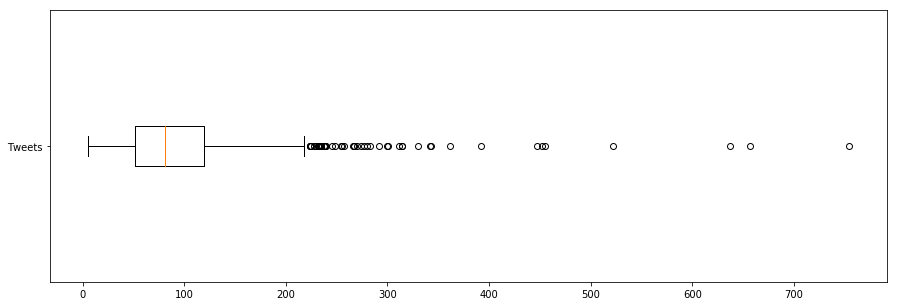

In [6]:
plt.figure(figsize = (15, 5))
plt.boxplot([len(text) for text in df['tweet']],    
    vert = False)
plt.yticks([1], ['Tweets'])
plt.show()

Los tweets tienen una longitud media de unos 80 caracteres. La cifra máxima oficial de caracteres de un tweet hoy en día es de 280 caracteres, por lo tanto podremos hacer un corte de los outliers duranate la fase de pre-procesado.

### 2.3. Vocabulario (palabras, bigramas y trigramas)

Visualizamos el vocabulario que conforma el corpus a nivel de palabras, bigramas y trigramas.

In [7]:
# función para el cálculo de palabras, bigramas y trigramas
def get_vocabulary(df, col_name):
    
    words_ = []
    bigrams_ = []
    trigrams_ = []
    
    # iteramos para cada tweet y cada palabra
    for tweet in df[col_name]:
        for word in tweet.split():
            words_.append(word)
    
    # generamos bigramas y trigramas
    bigrams_ = list(ngrams(words_, 2))
    trigrams_ = list(ngrams(words_, 3))
    
    # diccionario con las tres categorías
    vocab = {
        'words': words_,
        'bigrams': bigrams_,
        'trigrams': trigrams_
    }
    
    return vocab

In [8]:
# aplicamos get_vocabulary a nuestro corpus
twitter_vocabulary = get_vocabulary(df, 'tweet')

In [9]:
# función para representar "side by side"
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [10]:
# top 20 palabras
wf = Counter(twitter_vocabulary['words'])
wf_most_common = wf.most_common(20)

# top 20 bigramas
bg_freq = Counter(twitter_vocabulary['bigrams'])
bg_freq_most_common = bg_freq.most_common(20)

# top 20 trigramas
tg_freq = Counter(twitter_vocabulary['trigrams'])
tg_freq_most_common = tg_freq.most_common(20)

# data frames
df_w = pd.DataFrame(wf_most_common, columns = ['palabra', 'total'])
df_b = pd.DataFrame(bg_freq_most_common, columns = ['bigrama', 'total'])
df_t = pd.DataFrame(tg_freq_most_common, columns = ['trigrama', 'total'])

display_side_by_side(df_w, df_b, df_t)

palabra 
 total 
 
 
 
 
 0 
 a 
 9099 
 
 
 1 
 RT 
 7539 
 
 
 2 
 bitch 
 6638 
 
 
 3 
 the 
 6590 
 
 
 4 
 I 
 6472 
 
 
 5 
 to 
 5240 
 
 
 6 
 you 
 4881 
 
 
 7 
 and 
 3670 
 
 
 8 
 that 
 3111 
 
 
 9 
 my 
 3072 
 
 
 10 
 in 
 2902 
 
 
 11 
 is 
 2759 
 
 
 12 
 bitches 
 2576 
 
 
 13 
 like 
 2534 
 
 
 14 
 of 
 2503 
 
 
 15 
 on 
 2361 
 
 
 16 
 be 
 2304 
 
 
 17 
 me 
 2249 
 
 
 18 
 for 
 2023 
 
 
 19 
 hoes 
 1925 
 
 
 
 
 
 
 bigrama 
 total 
 
 
 
 
 0 
 (a, bitch) 
 1090 
 
 
 1 
 (in, the) 
 657 
 
 
 2 
 (like, a) 
 486 
 
 
 3 
 (a, hoe) 
 434 
 
 
 4 
 (that, bitch) 
 408 
 
 
 5 
 (to, be) 
 384 
 
 
 6 
 (I, don't) 
 378 
 
 
 7 
 (is, a) 
 376 
 
 
 8 
 (this, bitch) 
 355 
 
 
 9 
 (these, hoes) 
 341 
 
 
 10 
 (on, the) 
 338 
 
 
 11 
 (be, a) 
 316 
 
 
 12 
 (of, the) 
 284 
 
 
 13 
 (for, the) 
 280 
 
 
 14 
 (I, got) 
 248 
 
 
 15 
 (I, was) 
 239 
 
 
 16 
 (to, the) 
 235 
 
 
 17 
 (I, hate) 
 235 
 
 
 18 
 (bitch, RT) 
 227 
 
 
 19 
 (on, my) 
 221 
 
 
 
 
 
 
 trigrama 
 total 
 
 
 
 
 0 
 (a, bad, bitch) 
 86 
 
 
 1 
 (to, be, a) 
 78 
 
 
 2 
 (., ., .) 
 73 
 
 
 3 
 (look, like, a) 
 68 
 
 
 4 
 (like, a, bitch) 
 67 
 
 
 5 
 (I, hate, when) 
 61 
 
 
 6 
 (a, lot, of) 
 57 
 
 
 7 
 (a, bitch, that) 
 52 
 
 
 8 
 (is, a, bitch) 
 49 
 
 
 9 
 (in, this, bitch) 
 49 
 
 
 10 
 (a, little, bitch) 
 47 
 
 
 11 
 (be, a, bitch) 
 46 
 
 
 12 
 (a, bitch, RT) 
 45 
 
 
 13 
 (hoes, ain't, loyal) 
 43 
 
 
 14 
 (of, a, bitch) 
 40 
 
 
 15 
 (a, bitch, to) 
 40 
 
 
 16 
 (I, feel, like) 
 38 
 
 
 17 
 (son, of, a) 
 38 
 
 
 18 
 (in, the, pussy) 
 37 
 
 
 19 
 (bitch, ass, nigga) 
 35

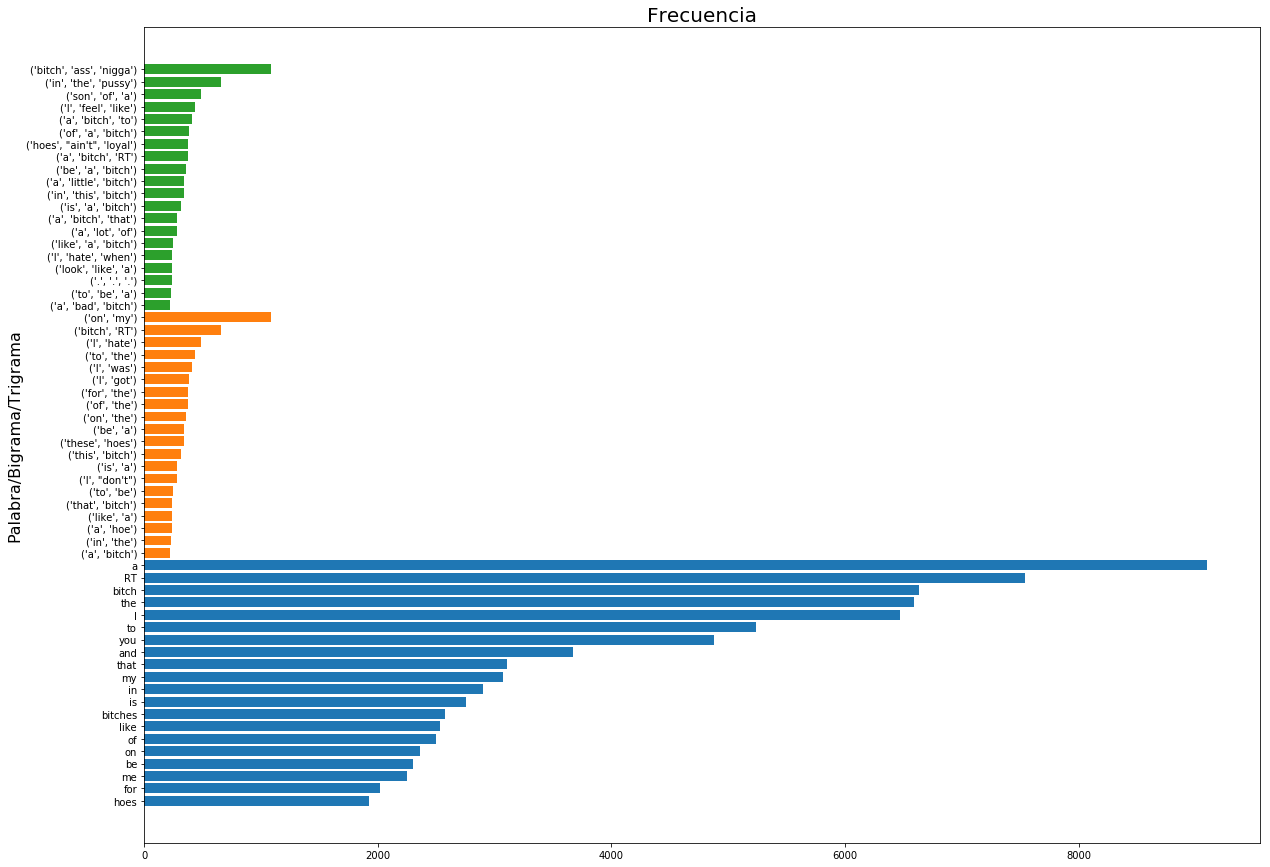

In [11]:
plt.rcParams['figure.figsize'] = (20, 15)

# palabras
words = [w[0] for w in wf_most_common]
freqs = [w[1] for w in wf_most_common]
freqs, words = zip(*sorted(zip(freqs, words)))

# bigramas
bgs_ = [str(bg[0]) for bg in bg_freq_most_common]
bgs_f_ = [bg[1] for bg in bg_freq_most_common]
bgs_f_, bgs_ = zip(*sorted(zip(bgs_f_, bgs_)))

# trigramas
tgs_ = [str(tg[0]) for tg in tg_freq_most_common]
tgs_f_ = [tg[1] for tg in tg_freq_most_common]
tgs_f_, bgs_ = zip(*sorted(zip(tgs_f_, bgs_)))
tgs_f_, tgs_ = zip(*sorted(zip(tgs_f_, tgs_)))

plt.barh(words, freqs)
plt.barh(bgs_, bgs_f_)
plt.barh(tgs_, bgs_f_)
plt.title('Frecuencia', fontsize = 20)
plt.ylabel('Palabra/Bigrama/Trigrama', fontsize = 16)

# display the plot
plt.show()

Resumen: el data set, aún sin preprocesar, muestra que el top 20 de palabras, bigramas y trigramas está compuesto por lenguaje ofensivo como insultos y palabras racistas.

### 2.4. Nube de palabras

El procesado implícito que se realiza al calcular la nube de palabras por clase de sentimiento, así como su representación jugando con el tamaño de la palabra en función de su frecuencia de aparición, permiten inferir, al menos a alto nivel, los sentimientos sobre las que se han calculado dichas nubes de palabras.

In [12]:
stopwords = set(STOPWORDS).add("RT")

# creamos las wordcloud
# total
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 100
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
    background_color = 'black',
    stopwords = stopwords,
    max_words = 200,
    max_font_size = 60, 
    random_state = 42
).generate(str(df)).recolor(color_func = random_color_func, random_state = 1)

# clase 0
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 344
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud0 = WordCloud(
    background_color = 'white',
    stopwords = stopwords,
    max_words = 200,
    max_font_size = 60, 
    random_state = 42
).generate(str(df.loc[df['class'] == 0])).recolor(color_func = random_color_func, random_state = 1)

# clase 1
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 20
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud1 = WordCloud(
    background_color = 'white',
    stopwords = stopwords,
    max_words = 200,
    max_font_size = 60, 
    random_state = 42
).generate(str(df.loc[df['class'] == 1])).recolor(color_func = random_color_func, random_state = 1)

# clase 2
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 180
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud2 = WordCloud(
    background_color = 'white',
    stopwords = stopwords,
    max_words = 200,
    max_font_size = 60, 
    random_state = 42
).generate(str(df.loc[df['class'] == 2])).recolor(color_func = random_color_func, random_state = 1)

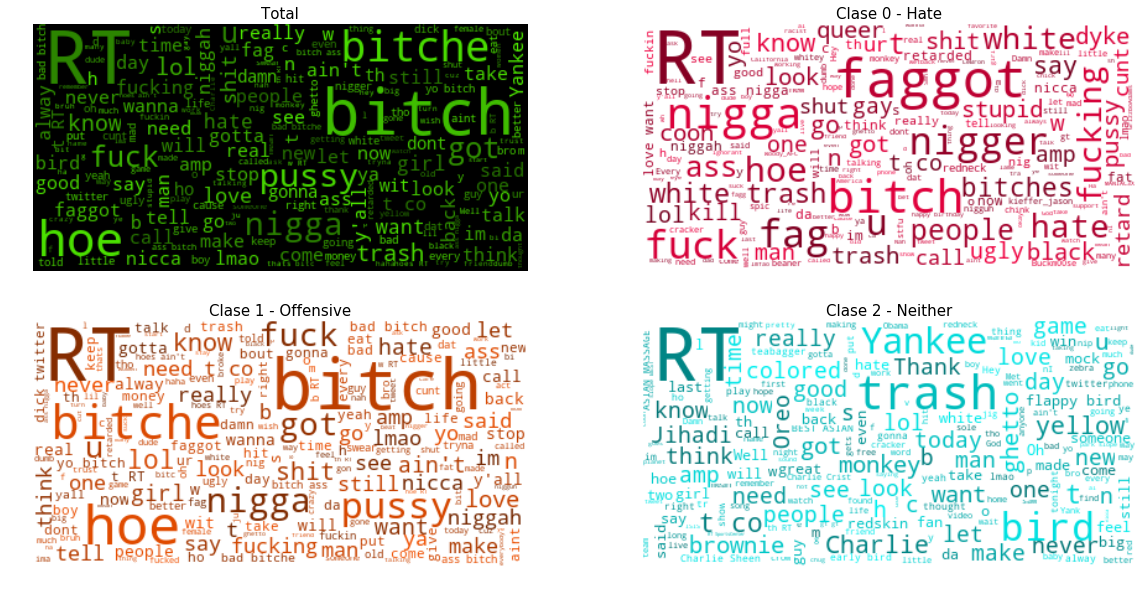

In [13]:
plt.figure(figsize = (20, 10))

# listas de wordclouds y sus nombres
wc = [wordcloud, wordcloud0, wordcloud1, wordcloud2]
wc_n = ['Total', 'Clase 0 - Hate', 'Clase 1 - Offensive', 'Clase 2 - Neither']

# representamos wordclouds
for i in range(0, 4):
    plt.subplot(2, 2, i+1)
    plt.imshow(wc[i], interpolation = 'bilinear')
    plt.axis('off')
    plt.title(wc_n[i], fontsize = 15)

### 2.5. Cardinalidad del vocabulario

Calculamos la cardinalidad del vocabulario del corpus considerado como el número de palabras únicas y además, calcuamos el total de palabras del corpus a modo informativo.

In [14]:
len(set(twitter_vocabulary['words']))

59006

In [15]:
len(twitter_vocabulary['words'])

349862

### 2.6. Riqueza léxica

La riqueza léxica de un documento es una medida de la varianza en el léxico utilizado. Dados dos documentos de igual extensión (número total de términos) aquel con mayor número de palabras (vocabulario con mayor cardinalidad) tendrá mayor riqueza léxica. Dicho valor también lo calcularemos una vez limpiados los datos para apreciar si en términos de cantidad de información se ha mejorado o no.

Existen diversas maneras de calcular la riqueza léxica. La más sencilla es dividiendo el número total de términos únicos entre el total de términos. Otras maneras de calcularla tienen en cuenta la categoría gramatical de los términos, si son informativos o no, etc.

A continuación aparece calculada la riqueza léxica para los tweets de la categoría considerada.

In [16]:
print('Riqueza léxica de las tweets de {}'
      .format(len(set(twitter_vocabulary['words']))/len(twitter_vocabulary['words'])*100))

Riqueza léxica de las tweets de 16.865506971320123


### 2.7. Distribución de tweets por sentimiento

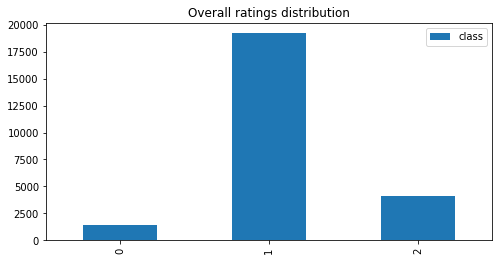

In [17]:
aux = pd.DataFrame(df['class'].value_counts(sort = False).sort_index())
ax = aux.plot(kind = 'bar', title = 'Overall ratings distribution', figsize = (8, 4))
ax

In [18]:
#Contamos objetos - @,#
df['Mention'] = df['tweet'].apply(lambda text: text.count('@'))
df['Hashtag'] = df['tweet'].apply(lambda text: text.count('#'))

In [19]:
df.head()

tweet  class  Mention  Hashtag
0  !!! RT @mayasolovely: As a woman you shouldn't...      2        1        0
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...      1        1        0
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...      1        2        0
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...      1        2        0
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...      1        1        1

In [20]:
# Filtramos por clase
df_hate = df[df['class'] == 0]
df_offensive = df[df['class'] == 1]
df_neither = df[df['class'] == 2]

# lista de DFs
df_list = [df_hate, df_offensive, df_neither]
# lista de títulos
t_list = ['Clase 0 - Hate', 'Clase 1 - Offensive', 'Clase 2 - Neither']

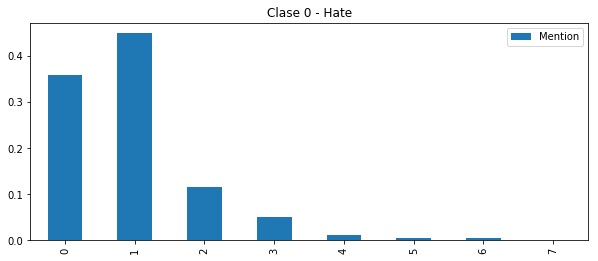

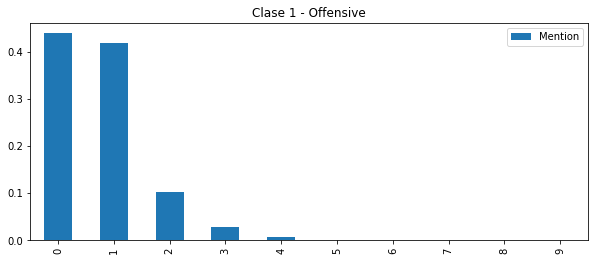

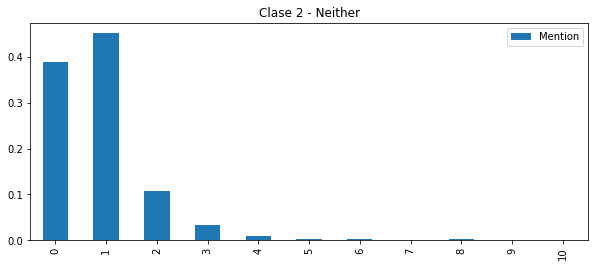

In [21]:
# representamos menciones
for i in range(0, 3):
    aux = pd.DataFrame(df_list[i]['Mention'].value_counts(sort = False, normalize = True).sort_index())
    ax = aux.plot(kind = 'bar', title = t_list[i], figsize = (10, 4))

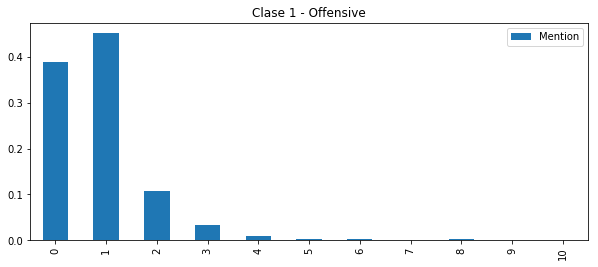

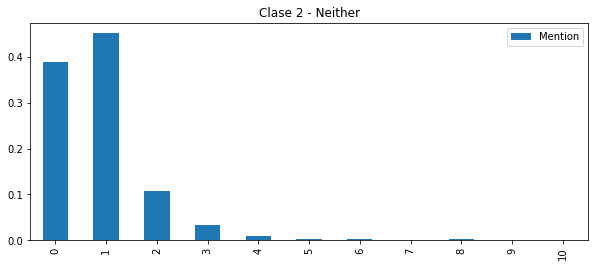

In [22]:
# representamos hashtags
for i in range(0, 3):
    aux2 = pd.DataFrame(df_list[i]['Hashtag'].value_counts(sort = False, normalize = True).sort_index())
    ax2 = aux.plot(kind = 'bar', title = t_list[i], figsize = (10, 4))

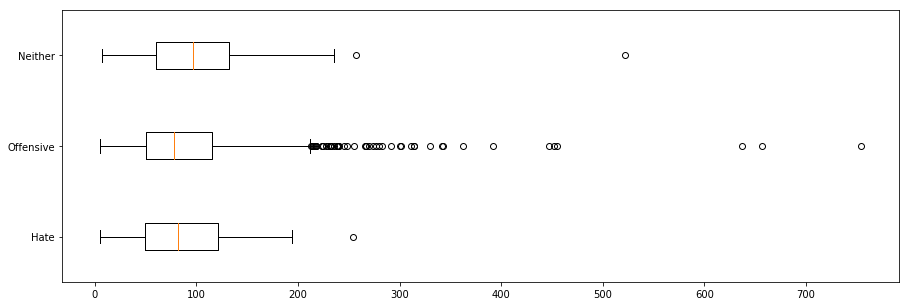

In [23]:
plt.figure(figsize = (15, 5))
plt.boxplot([[len(tweet) for tweet in df_hate['tweet']],
             [len(tweet) for tweet in df_offensive['tweet']],
             [len(tweet) for tweet in df_neither['tweet']],
            ],
    vert = False)
plt.yticks([1,2,3], ['Hate', 'Offensive', 'Neither'])
plt.show()